In [13]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch

#other libraries
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
import atlas_mpl_style as ampl

In [14]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18
import glest

In [15]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
#LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
#PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
PLOT_ORDER = [0, 2, 1, 3, 5, 4]
#PLOT_ORDER = [0, 1, 2, 3]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
#FOLDERS = ["sph", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT=True
LOAD_VALUES = True

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet18_1703078471_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
#MODEL_NAME = "resnet18_1717668230_SPH_9_BH_n4_M8_BH_n4_M10_BH_n4_M12_CUT"
LOAD_FOLDER = "../results/models/experiment_resnet18_1703074946_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT"
#LOAD_FOLDER = "../results/models/experiment_resnet18_1717668204_SPH_9_BH_n4_M8_BH_n4_M10_BH_n4_M12_CUT"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"
paper_colors = ['#4c72b0','#dd8452', '#55a868',  '#c44e52',  '#8172b3', '#937860']
#paper_colors = ['#4c72b0','#dd8452', '#55a868',  '#c44e52']

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
DEVICE = torch.device("cpu")
ampl.use_atlas_style() 

Running on the GPU


In [16]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [17]:
#Load data
if LOAD_VALUES:
    truth = np.load(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_truth.npy")
    preds = np.load(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_preds.npy")
    confidences = np.load(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_confidences.npy")
    embeddings = np.load(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_embeddings.npy")
else:
    testpaths = [Path(path) for path in TEST_DATAPATHS]
    test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters=[None], transforms=None)
    test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                            shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)
    truth, preds, confidences, embeddings = predict(model, test_data, CLASSES, 100, RES, DEVICE, return_conf=True, return_fc=True)
    np.save(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_truth.npy", truth)
    np.save(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_preds.npy", preds)
    np.save(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_confidences.npy", confidences)
    np.save(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_events_embeddings.npy", embeddings)

In [18]:
#Convert labels from integers to one-hot-vectors
def integer_to_vector(array, n_classes):
    vectors = np.zeros((len(array), n_classes))
    for i, value in enumerate(array):
        vectors[i][int(value)] = 1
    return vectors

truth_vectors = integer_to_vector(truth, CLASSES)
preds_vectors = integer_to_vector(preds, CLASSES)
confidences = np.array(confidences.tolist())

## Look at raw output

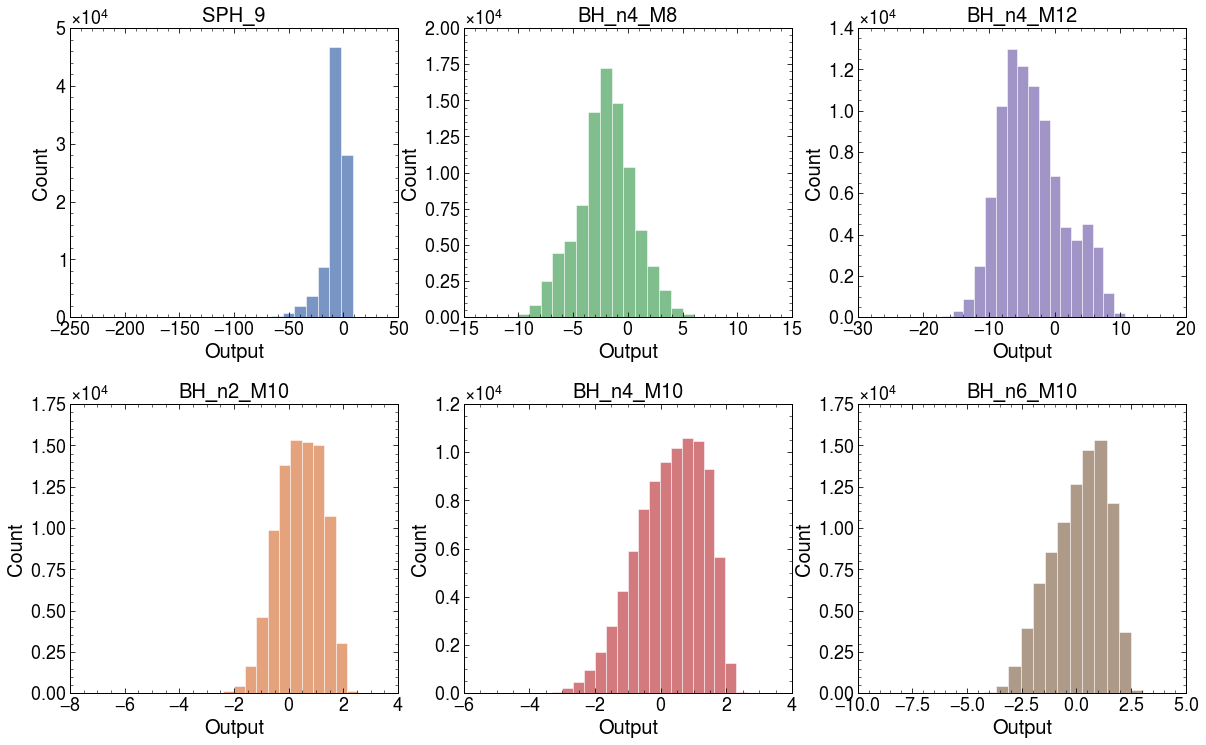

In [19]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    sn.histplot(embeddings[:,i], bins=20, ax=ax[i%2][i//2], color = paper_colors[i])
    ax[i%2][i//2].set_title(PLOT_LABELS[PLOT_ORDER[i]])
    ax[i%2][i//2].set_xlabel("Output")

## Look at softmax output (confidences)

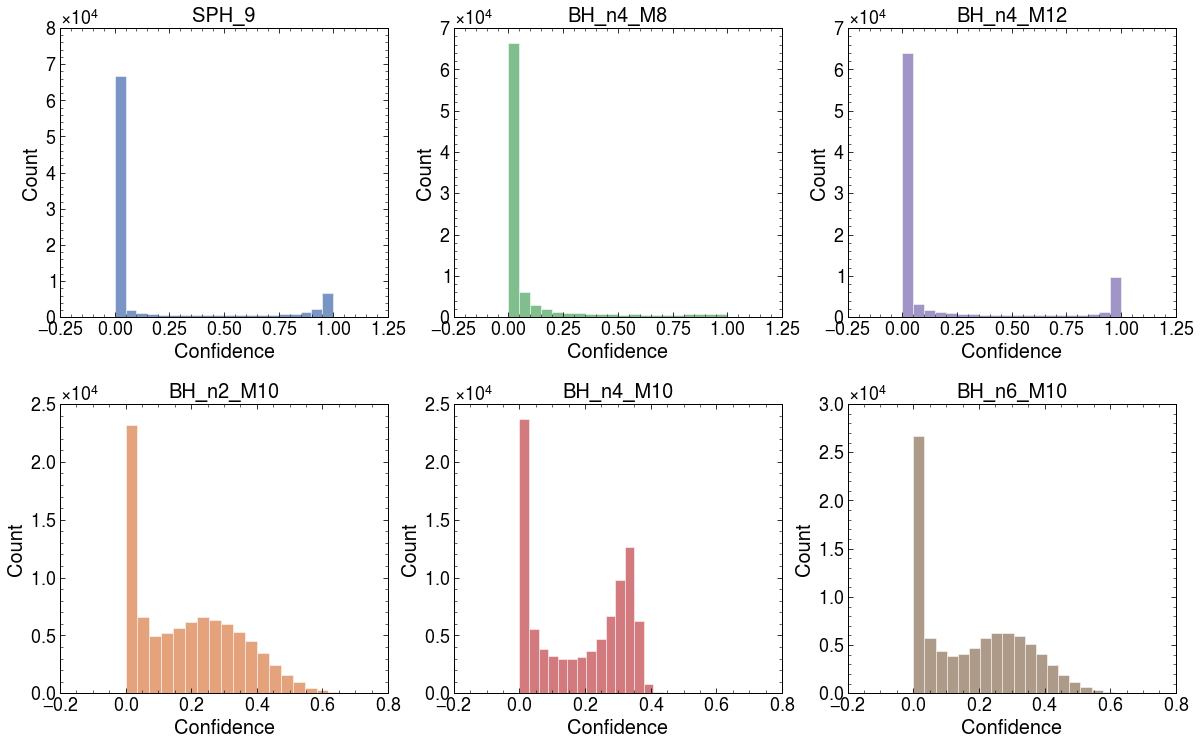

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    sn.histplot(confidences[:,i], bins=20, ax=ax[i%2][i//2], color = paper_colors[i])
    ax[i%2][i//2].set_title(PLOT_LABELS[PLOT_ORDER[i]])
    ax[i%2][i//2].set_xlabel("Confidence")

In [40]:

df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
df["Model"] = 0
predicted_conf = [confidences[i, int(j)].tolist() for i,j in enumerate(preds.tolist())]
df["Confidence"] = predicted_conf
predicted_embedding = [embeddings[i, int(j)].tolist() for i,j in enumerate(preds.tolist())]
df["Output"] = predicted_embedding
correct_conf = np.zeros(len(df))
for i in range(len(df)):
    if df["Truth"][i]==df["Predictions"][i]:
        correct_conf[i] = 1
    else:
        correct_conf[i] = 0
df["Correct_Conf"] = correct_conf
df[["Truth", "Predictions"]] = df[["Truth", "Predictions"]].astype(int)
max_output = 0
min_output = 0
for i, label in enumerate(LABELS):
    output = embeddings[:, i].tolist()
    df[f"Output_class_{i}"] = output
    if max_output < df[f"Output_class_{i}"].max():
        max_output = df[f"Output_class_{i}"].max()
    if min_output > df[f"Output_class_{i}"].min():
        min_output = df[f"Output_class_{i}"].min()
    
    df["Model"][df["Truth"]==i] = label

/tmp/ipykernel_21972/1158252267.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Model"][df["Truth"]==i] = label
/tmp/ipykernel_21972/1158252267.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df["Model"][df["Truth"]==i] = label


In [39]:
df

,Truth,Predictions,Model,Confidence,Output,Correct_Conf,Output_class_0,Output_class_1,Output_class_2,Output_class_3,Output_class_4,Output_class_5
0,0,1,PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL,0.392119,0.690834,0.0,0.386430,0.690834,-3.330407,-0.122148,-4.753408,-0.367884
1,0,0,PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL,0.981037,4.477528,1.0,4.477528,-0.049566,-1.109876,-1.352874,-8.293910,-1.824408
2,0,0,PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL,0.960664,3.546191,1.0,3.546191,0.022516,-2.940412,-1.705517,-2.724868,-2.330902
3,0,3,PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL,0.317883,0.298282,0.0,-3.080913,0.273789,-1.966639,0.298282,-1.072526,0.047500
4,0,0,PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL,0.636638,1.893313,1.0,1.893313,0.357963,-0.132547,-0.169406,-7.373305,-0.447099
...,...,...,...,...,...,...,...,...,...,...,...,...
89995,5,1,BH_n6_M10,0.554192,1.532220,0.0,-2.844839,1.532220,-1.860288,0.660083,-6.643563,0.453122
89996,5,1,BH_n6_M10,0.356590,1.163205,0.0,-1.246054,1.163205,0.105939,0.898140,-8.857882,0.652139
89997,5,3,BH_n6_M10,0.303160,1.070868,0.0,-8.051974,0.644887,0.636357,1.070868,-5.466850,1.067186
89998,5,3,BH_n6_M10,0.363281,1.013183,0.0,-11.900470,0.804674,-3.752066,1.013183,-1.255494,0.825552


[91.2   1.91  6.31  0.15  0.18  0.25 11.98 56.69 12.58  5.26 12.37  1.12
  5.99  2.79 49.33 11.15 22.18  8.56  3.23  3.47 35.09 13.36 35.85  8.99
  2.66  3.91 28.88 13.6  42.07  8.87  0.59  0.31  3.19  1.13  2.35 92.43]
Accuracy: 0.5751444444444445


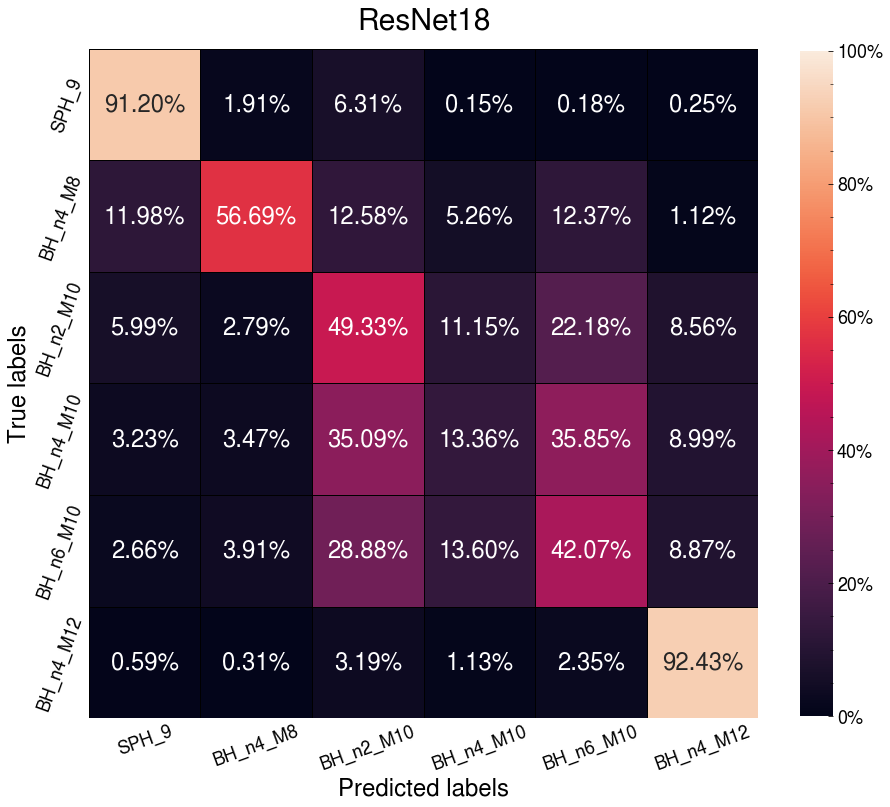

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(15, 15))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    cf_matrix = np.array([cf_matrix[i] for i in PLOT_ORDER])
    cf_matrix = np.array([np.array([row[j] for j in PLOT_ORDER]) for row in cf_matrix])
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=18, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=18, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18", size=30, pad=20)
    print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    fig.savefig(f"../results/figures/ResNet18_{TEST_N_EVENTS}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    plt.show()
accuracy = accuracy_score(truth, preds, normalize=True)
plot_conf_matrix(df, accuracy, PLOT_LABELS)


In [22]:
df.to_csv(f"../results/calibration/{MODEL_NAME}_{TEST_N_EVENTS}_values.csv", index=False)

# Top level calibration

<Axes: xlabel='Confidence', ylabel='Count'>

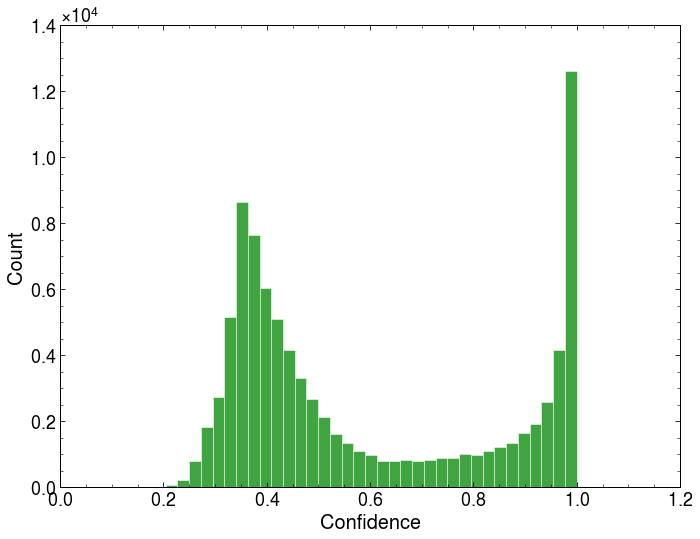

In [23]:
sn.histplot(df["Confidence"])

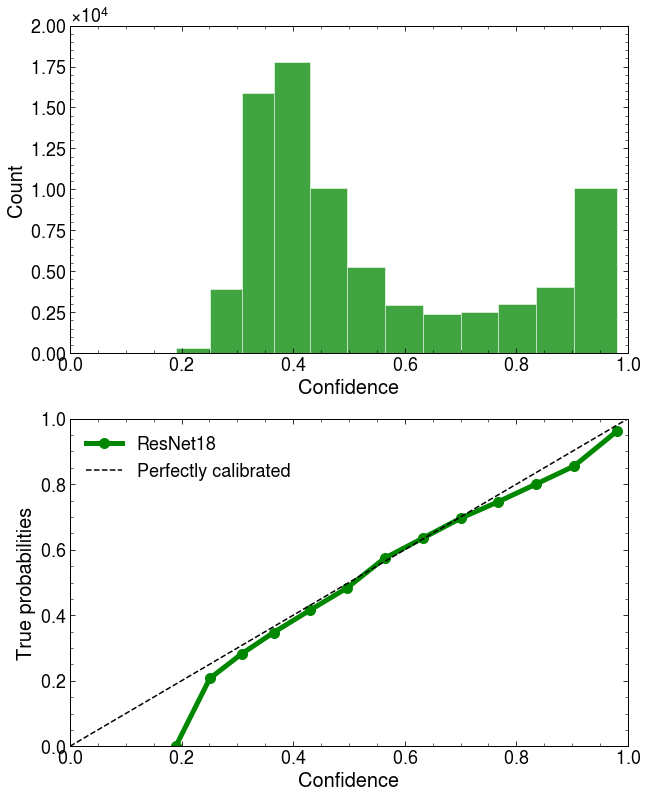

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))

prob_true, prob_pred = calibration_curve(df["Correct_Conf"], df["Confidence"], n_bins=15, strategy="uniform")
pred_bins=list(prob_pred)

sn.histplot(df["Confidence"], ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_true, linewidth=5, markersize=10, marker="o", label ="ResNet18")
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("Confidence")
ax[1].set_ylabel("True probabilities")
ax[1].legend()

# Class-wise calibration

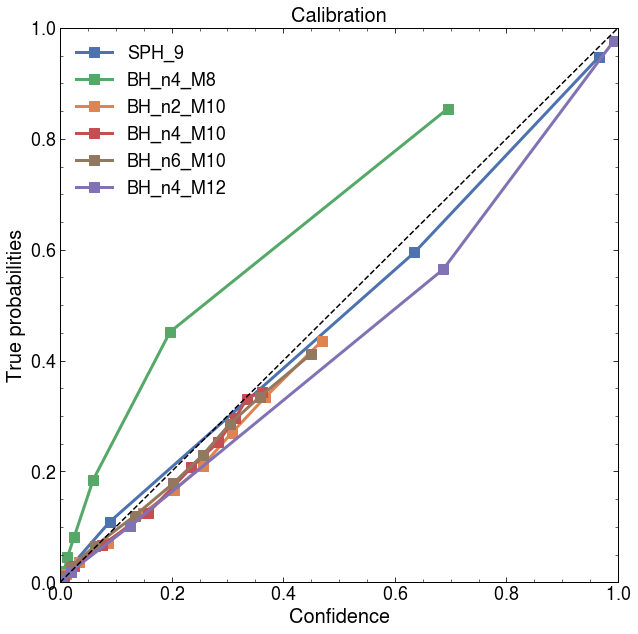

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
for i in range(CLASSES):
    prob_true_i, prob_pred_i = calibration_curve(truth_vectors[:,PLOT_ORDER[i]], confidences[:,PLOT_ORDER[i]], n_bins=10, strategy="quantile")
    ax.plot(prob_pred_i, prob_true_i, linewidth=3, markersize=10, marker="s", color=paper_colors[PLOT_ORDER[i]], label=PLOT_LABELS[i])
x = np.linspace(0, 1, 10)
ax.plot(x, x, color="black", linestyle="--")
ax.set_title("Calibration")
ax.set_xlabel("Confidence")
ax.set_ylabel("True probabilities")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()

In [26]:
from glest.core import GLEstimator
glest = GLEstimator(predicted_conf, partitioner="decision_tree", train_size=0.5, random_state=0)


In [27]:
print(embeddings[0].shape)
print(len(predicted_conf))
print(len(correct_conf))

(6,)
90000
90000


In [28]:
glest.fit(embeddings, correct_conf)

KeyboardInterrupt: 

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0042
   ↳ Uncorrected GL : 0.0165
   ↳ Bias           : 0.0112
   ↳ Binning induced: 0.0011



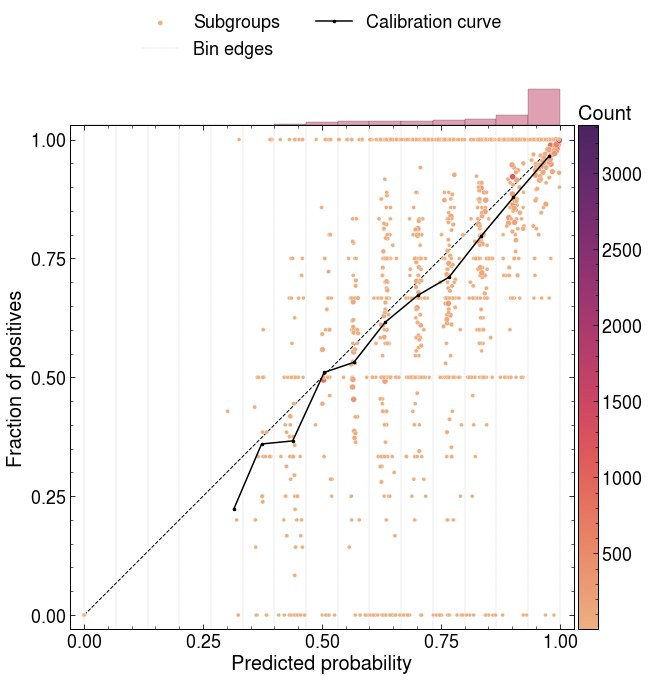

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
fig = glest.plot(ax=ax)
print(glest)

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0052
   ↳ Uncorrected GL : 0.0131
   ↳ Bias           : 0.0071
   ↳ Binning induced: 0.0008



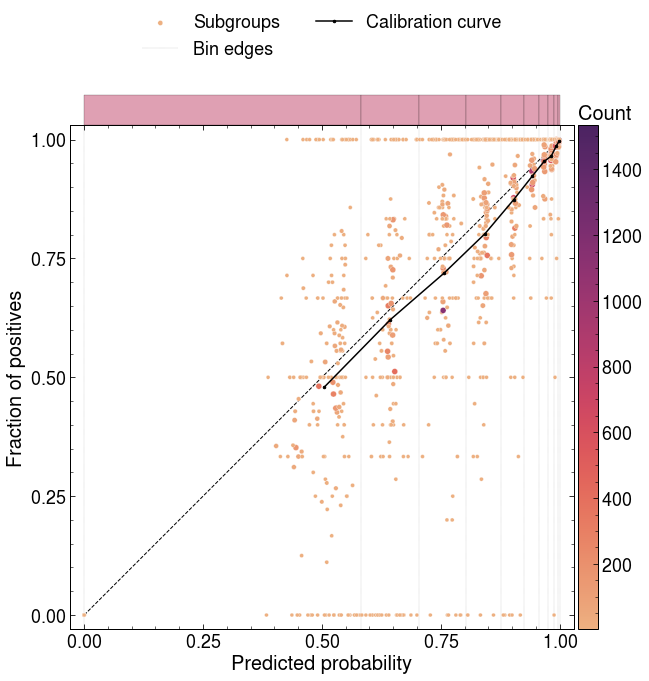

In [ ]:
from glest.core import Partitioner

partitioner = Partitioner.from_name("decision_tree", n_bins=10, strategy="quantile")

glest = GLEstimator(predicted_conf, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(embeddings, correct_conf)
fig = glest.plot(fig_kw=dict(figsize=(10, 10)))
print(glest)

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : 0.0052
   ↳ Uncorrected GL : 0.0131
   ↳ Bias           : 0.0071
   ↳ Binning induced: 0.0008



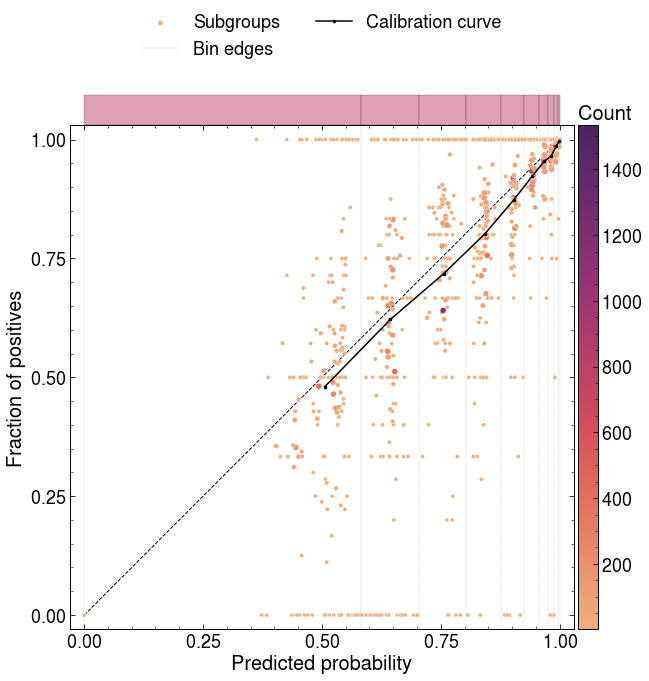

In [ ]:
from sklearn.tree import DecisionTreeClassifier

partitioner_est = DecisionTreeClassifier(max_depth=10, random_state=0)
partitioner = Partitioner(partitioner_est, n_bins=10, strategy="quantile", predict_method="apply")

glest = GLEstimator(predicted_conf, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(embeddings, correct_conf)
fig = glest.plot(fig_kw=dict(figsize=(10, 10)))
print(glest)

GLEstimator()
  Scoring Rule      : brier
  Grouping loss     : -0.0002
   ↳ Uncorrected GL : 0.0008
   ↳ Bias           : 0.0002
   ↳ Binning induced: 0.0008



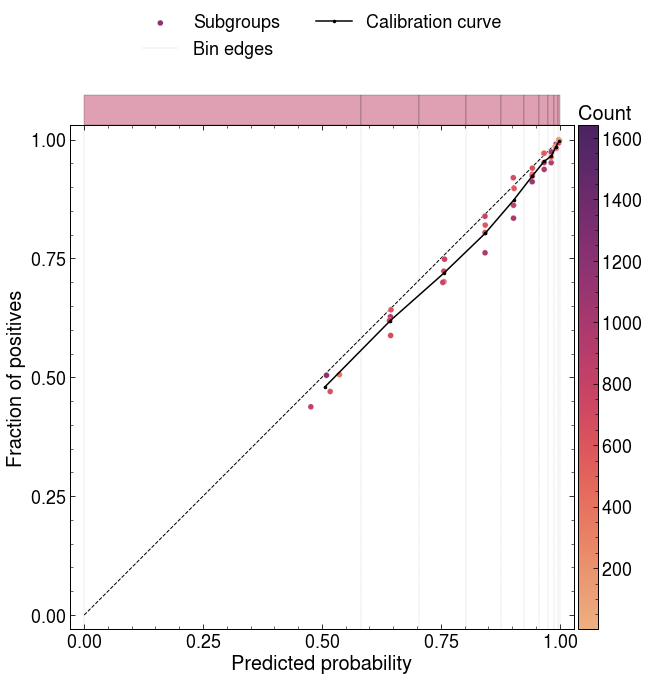

In [ ]:
from sklearn.cluster import KMeans

partitioner_est = KMeans(n_clusters=4, random_state=0, n_init="auto")
partitioner = Partitioner(partitioner_est, n_bins=10, strategy="quantile", predict_method="predict")

glest = GLEstimator(predicted_conf, partitioner=partitioner, train_size=0.5, random_state=0)
glest.fit(embeddings, correct_conf)
fig = glest.plot(fig_kw=dict(figsize=(10, 10)))
print(glest)